C:\Users\user\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\user\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


📋 Classification Report of the Loaded Model:
                      precision    recall  f1-score   support

      Apple__Healthy       0.95      0.94      0.95       367
       Apple__Rotten       0.94      0.91      0.93       440
     Banana__Healthy       0.99      0.98      0.98       300
      Banana__Rotten       0.98      0.99      0.99       421
 Bellpepper__Healthy       0.88      0.99      0.93        93
  Bellpepper__Rotten       0.80      0.82      0.81        90
     Carrot__Healthy       0.86      0.99      0.92        93
      Carrot__Rotten       0.93      0.77      0.84        87
   Cucumber__Healthy       0.88      0.99      0.93        92
    Cucumber__Rotten       0.99      0.82      0.90        90
      Grape__Healthy       0.93      0.93      0.93        30
       Grape__Rotten       0.97      0.93      0.95        30
      Guava__Healthy       1.00      1.00      1.00        30
       Guava__Rotten       0.82      0.77      0.79        30
     Jujube__Healthy    

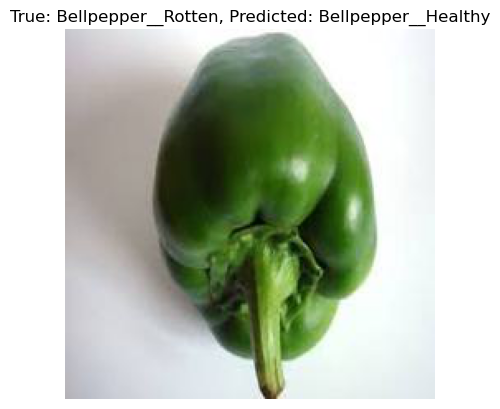

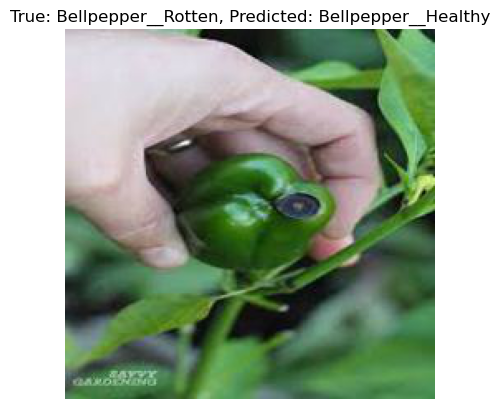

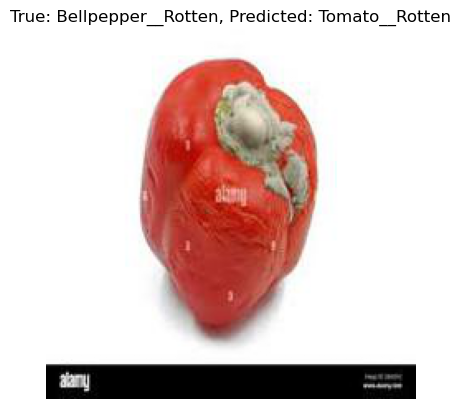

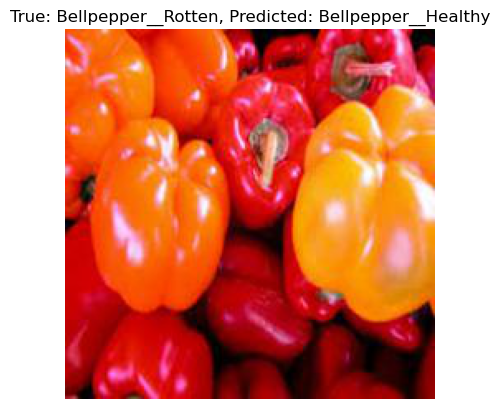

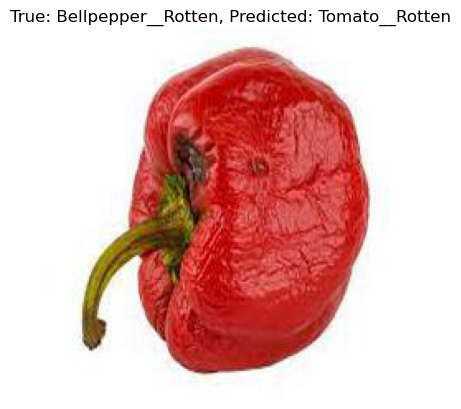


--- Misclassified examples for class: Carrot__Rotten ---


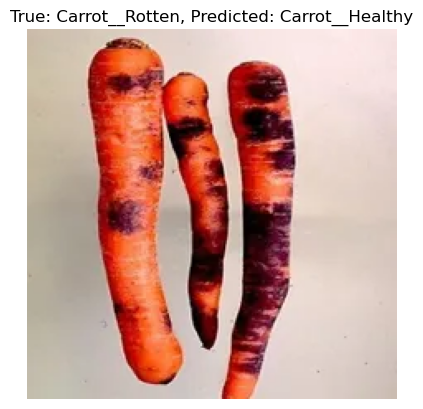

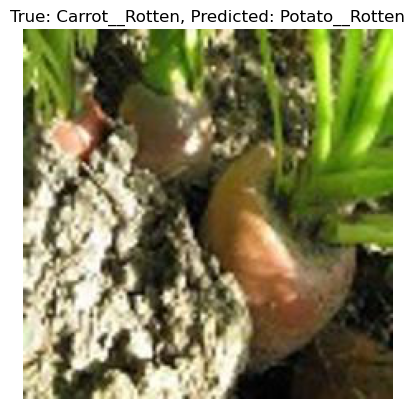

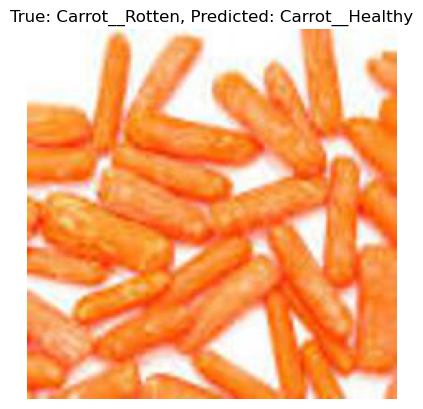

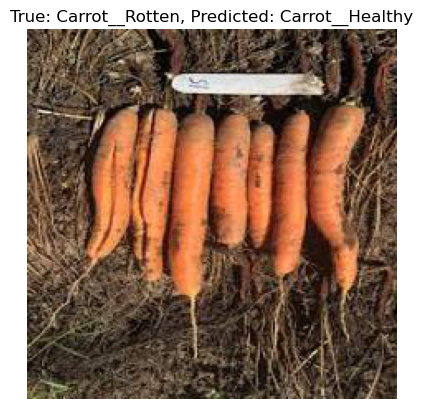

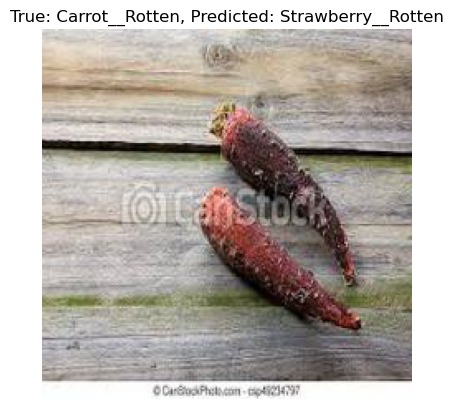


--- Misclassified examples for class: Cucumber__Rotten ---


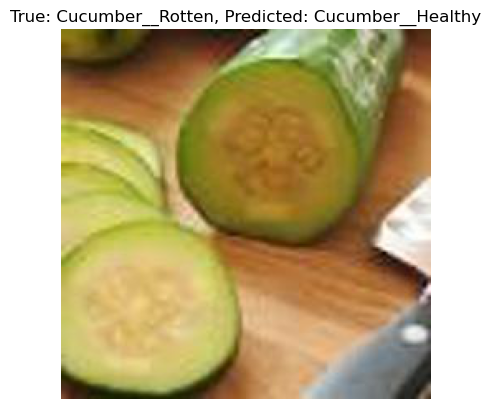

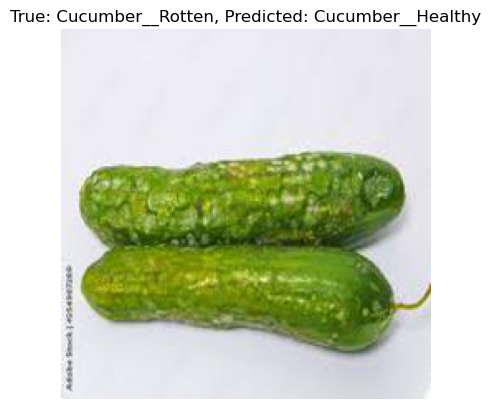

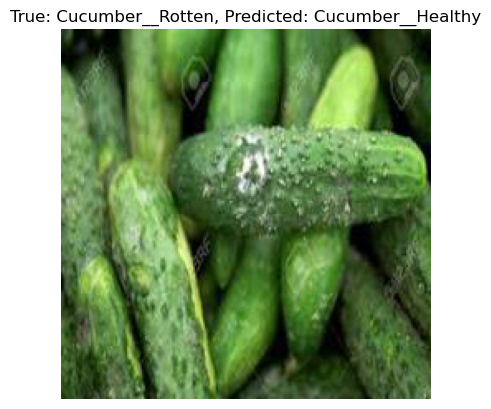

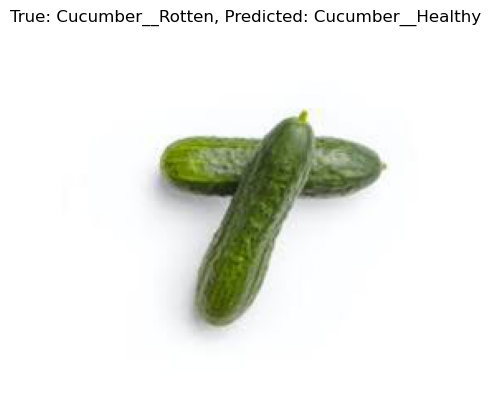

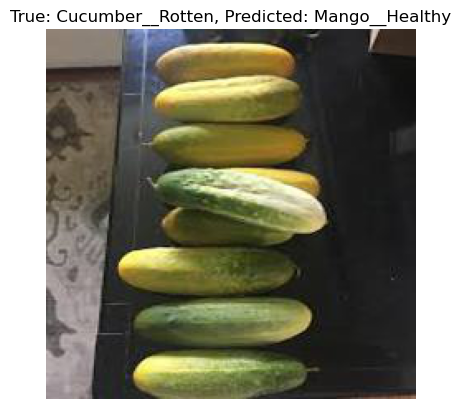


--- Misclassified examples for class: Guava__Rotten ---


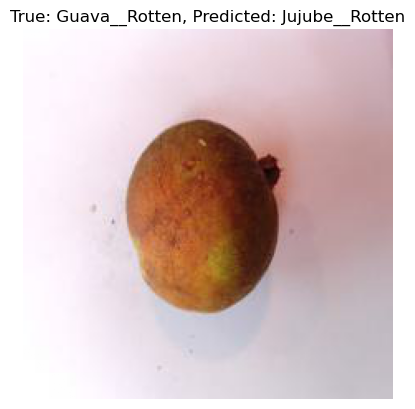

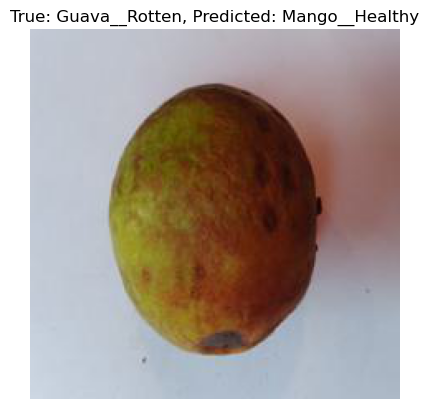

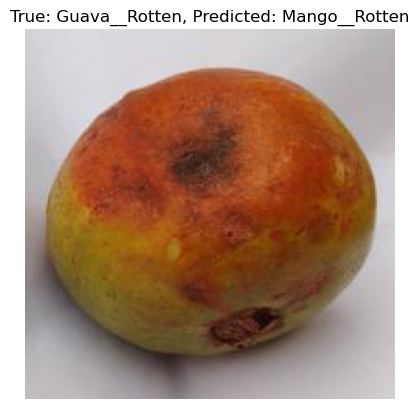

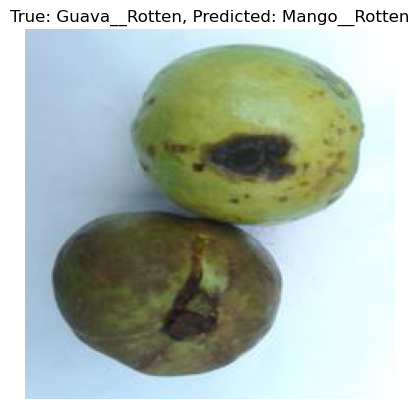

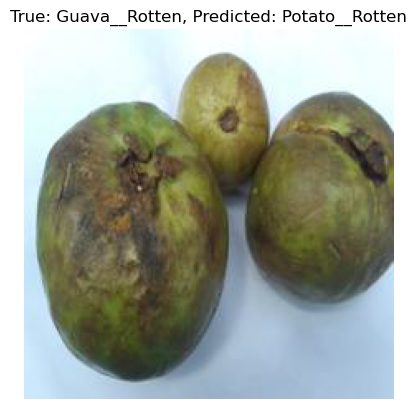


--- Misclassified examples for class: Jujube__Rotten ---


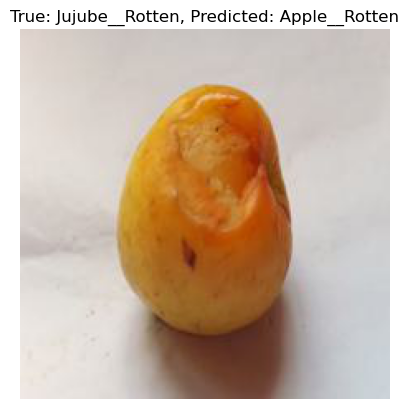

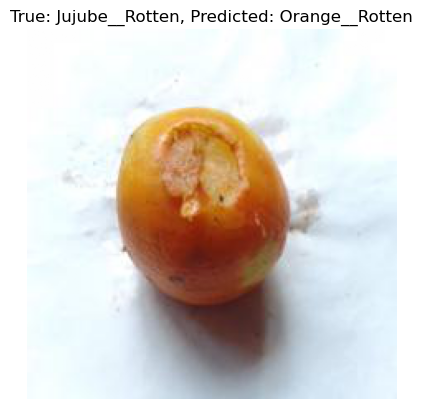

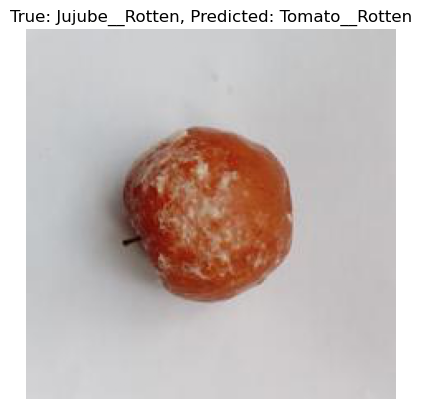

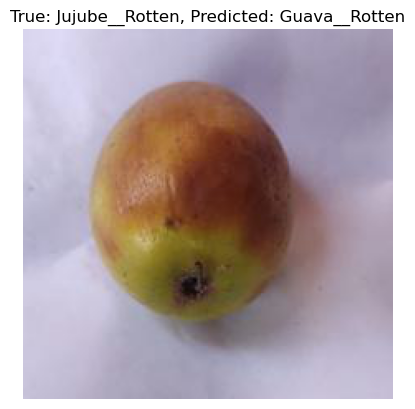

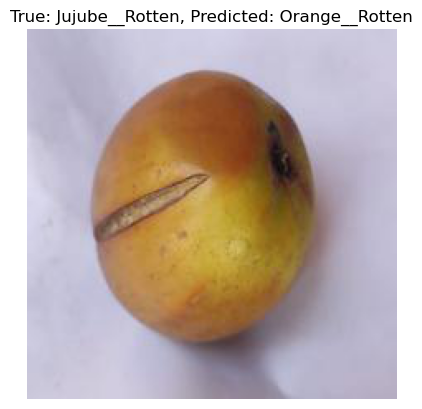


--- Misclassified examples for class: Pomegranate__Rotten ---


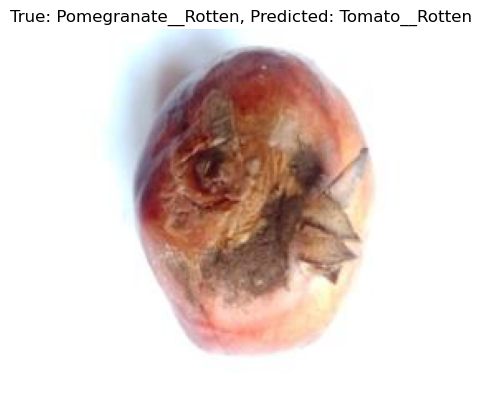

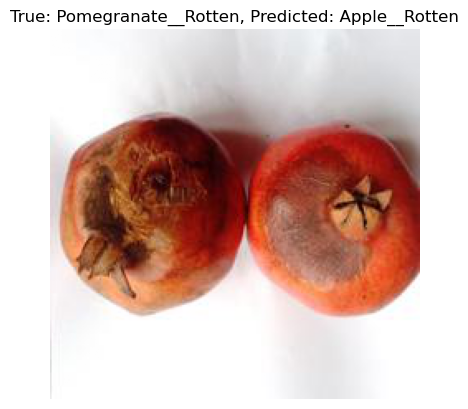

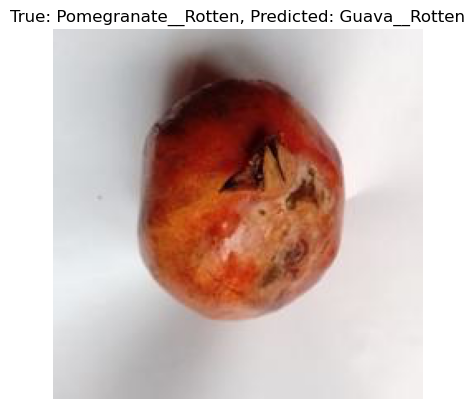

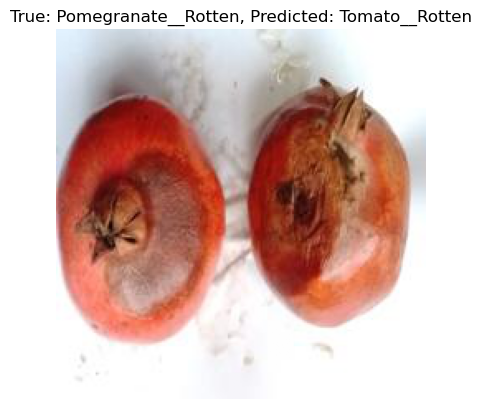


--- Misclassified examples for class: Potato__Rotten ---


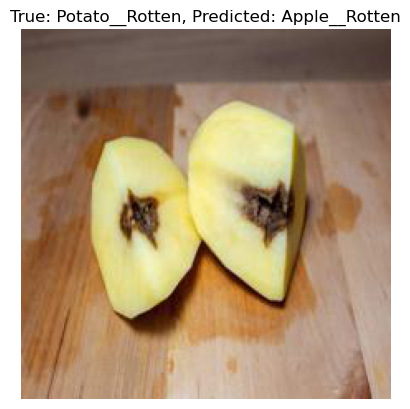

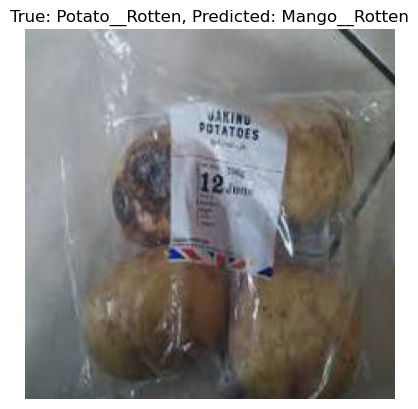

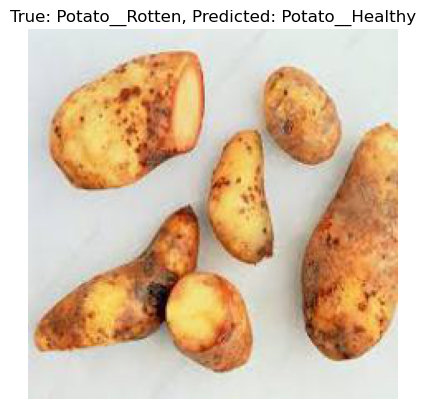

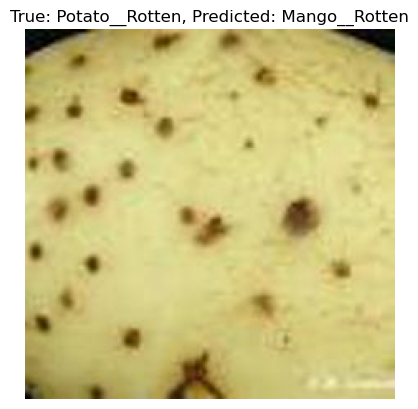

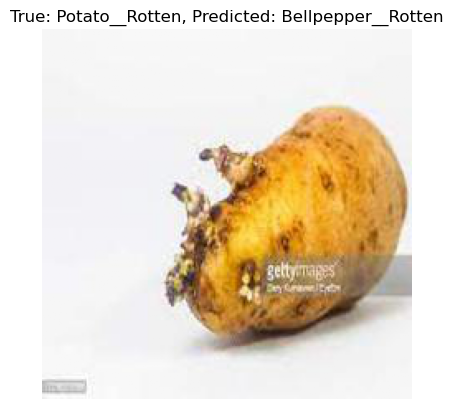


--- Misclassified examples for class: Tomato__Rotten ---


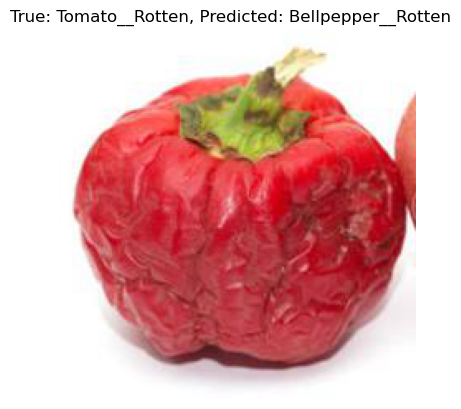

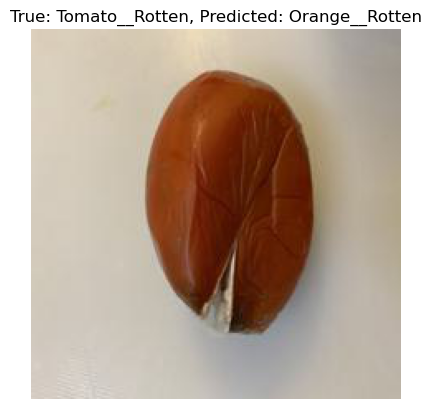

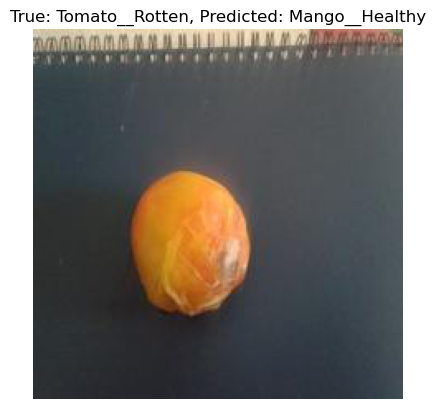

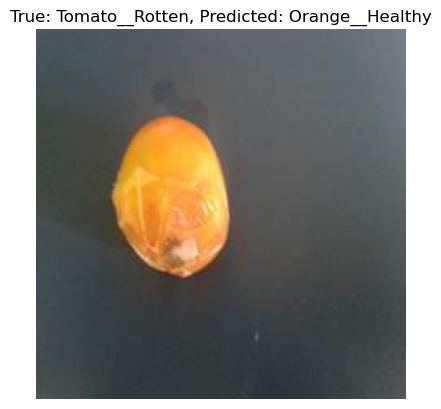

In [1]:
# Import libraries
import torch
import torch.nn as nn
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import os
from PIL import Image, ImageDraw, ImageFont

# Define data directory (adjust if necessary)
data_dir = "data/processed/"

# Define transformations for the test set (same as before)
transform_test = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

# Load the test dataset
test_dataset = datasets.ImageFolder(os.path.join(data_dir, 'test'), transform=transform_test)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False) # No need to shuffle for evaluation
class_names = test_dataset.classes
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the best model
model_path = 'model/best_resnet_model.pth'
model = models.resnet18(pretrained=False) # Instantiate the model architecture
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, len(class_names))
model.load_state_dict(torch.load(model_path, map_location=device))
model.eval()  # Set the model to evaluation mode

# Function to get predictions and true labels
def get_predictions(model, data_loader, device):
    model.eval()
    y_true = []
    y_pred = []
    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())
    return y_true, y_pred

# Get predictions on the test set
y_true, y_pred = get_predictions(model, test_loader, device)

# Print the classification report again for reference
print("📋 Classification Report of the Loaded Model:")
print(classification_report(y_true, y_pred, target_names=class_names))

# Analyze misclassified images for low-performing classes
def analyze_misclassified(y_true, y_pred, class_names, dataset, num_images=5):
    misclassified_indices = np.where(np.array(y_true) != np.array(y_pred))[0]
    misclassified_samples = []
    for index in misclassified_indices:
        misclassified_samples.append({
            'index': index,
            'true_label': class_names[y_true[index]],
            'predicted_label': class_names[y_pred[index]],
            'image': dataset[index][0]
        })

    # Identify classes with lower performance (e.g., F1-score < 0.90)
    report = classification_report(y_true, y_pred, target_names=class_names, output_dict=True)
    low_performing_classes = [
        class_name for class_name, metrics in report.items()
        if isinstance(metrics, dict) and metrics['f1-score'] < 0.90
    ]

    print("\n🔍 Analyzing Misclassified Images for Low-Performing Classes:")
    for class_name in low_performing_classes:
        print(f"\n--- Misclassified examples for class: {class_name} ---")
        count = 0
        for sample in misclassified_samples:
            if sample['true_label'] == class_name and count < num_images:
                plt.imshow(sample['image'].permute(1, 2, 0) / 2 + 0.5) # Unnormalize and display
                plt.title(f"True: {sample['true_label']}, Predicted: {sample['predicted_label']}")
                plt.axis('off')
                plt.show()
                count += 1
        if count == 0:
            print("No misclassified examples found for this class in the displayed set.")

# Run the misclassification analysis
analyze_misclassified(y_true, y_pred, class_names, test_dataset)

